#### EstNLTK testimisplokk

In [21]:
from estnltk import Text
#import estnltk

In [22]:
text = Text("See on lause testimiseks.")

In [23]:
text.text

'See on lause testimiseks.'

In [24]:
text = Text('Ma ei hooli juveelidest. Mulle meeldivad lilled.')
text.tag_layer(['words', 'sentences', 'morph_analysis'])

# Ask for morph_analysis layer
for lemma in text['morph_analysis']['lemma']:
    print(lemma[0])

mina
ei
hoolima
juveel
.
mina
meeldima
lill
.


### Säutsude sisu tehniline liigitus. 
Tuleks eristada originaalsäutse ja tsitaate (retweet), nt märkida ära metaandmetesse,millal on tegemist tsitaadiga. Kusjuures, metaandmetes võib juba olla mingi tsitaati näitav andmeväli, aga minu senine kogumus ütleb, et Twitteri enda metaandmed pole alati usaldusväärsed. Ühesõnaga, tuleks uurida, kuivõrd saab usaldada Twitteri metaandmeid.

Teine nö tehniline sisu puudutav teema: mõnikord on säutse lühendatud ("truncated"). Jällegi, meta-andmetes võib see kirjas olla, aga kuivõrd usaldusväärne see on? Paistab, et sageli annavad sellest märku 3 punkti ja/või lühike veebiaadress säutsu lõpus. Ka siin oleks hea, kui saaks sellised säutsud eraldi ära märkida.

Kogu selle töötluse eesmärk on eristada, palju on meil analüüsimiseks originaalsäutse (selliseid, mis sobivad tekstianalüüsiks) ja palju on korduseid vms "moonutatud" säutse;

In [6]:
import json

from estnltk import Text
from estnltk.converters import text_to_dict, dict_to_text

# Säutsu ja selle meta-andmete lugemine json-kujult.
# Liides analoogne EstNLTK funktsiooniga json_to_text,
# ainult et tagastab paari: säutsu Text objekt ja meta-andmed
def json_to_tweet_text( json_text=None, file=None, file_encoding='utf-8'):
    assert json_text is not None or file is not None
    assert isinstance(json_text, str) or isinstance(file, str)
    if file:
        with open(file, 'r', encoding=file_encoding) as in_f:
            text_obj_dict = json.load(fp=in_f)
    elif json_text:
        text_obj_dict = json.loads(json_text)
    else:
        raise TypeError("either 'text_json' or 'file' argument needed")
    assert 'tweet_meta' in text_obj_dict.keys()
    # Eraldame Text objekti ja säutsu meta-andmed
    tweet_metadata = text_obj_dict.pop( 'tweet_meta' )
    return dict_to_text(text_obj_dict), tweet_metadata

# Säutsu ja selle meta-andmete konverteerimine json kujule.
# Liides analoogne EstNLTK funktsiooniga text_to_json,
# ainult et säutsu Text objekt ja meta-andmed tuleb eraldi 
# parameetritena ette anda;
def tweet_text_to_json( text_obj, tweet_metadata, file=None, file_encoding='utf-8' ):
    assert isinstance(tweet_metadata, dict)
    assert isinstance(text_obj, Text)
    text_obj_dict = text_to_dict(text_obj)
    # Mestime Text objekti ja säutsu meta-andmed
    text_obj_dict['tweet_meta'] = tweet_metadata
    if file is None:
        return json.dumps(text_obj_dict, ensure_ascii=False)
    with open(file, 'w', encoding=file_encoding) as out_f:
        json.dump(text_obj_dict, fp=out_f, ensure_ascii=False)

# Säutsu faili lõppu kirjutamine rida-rea kaupa
def write_tweet( text_obj, tweet_metadata, output_file ):
    # faili kirjutamine
    with open(output_file, 'a', encoding='utf-8') as out_f:
        # teeme säutsu Text objekti ja metaandmed üheks json sõneks:
        tweet_json_string = tweet_text_to_json( text_obj, tweet_metadata, file=None )
        # kirjutame json sõne faili, uuele reale
        out_f.write( tweet_json_string )
        out_f.write( '\n' )

In [7]:
input_file = 'data/EstNLP projektide andmed/2018_est_twitter_plain_texts/est_twitter_2018_june_plain_texts.jsonl'

In [ ]:
### Säutsude lugemine ###

import os
from pprint import pprint

tweet_count = 0
rt_count = 0
trunc_count = 0
meta_rt_count = 0
meta_trunc_count = 0
with open(input_file, 'r', encoding='utf-8') as in_file:
    for line in in_file:
        json_line_str = line.strip()
        # Loeme JSON-ist säutsu Text objekti ja meta-andmed
        text_obj, tweet_metadata = json_to_tweet_text( json_text=json_line_str )
        # Säutsu Text objekt
        #display( text_obj )
                
        words = text_obj.text.split()
        #print(words)
        # Kas säuts on edasipostitus
        rt = False
        if words[0] == 'RT':
            rt = True
            rt_count += 1
            #print("RT")
        
        last_w_chars = list(words[len(words)-1])        
        #print(last_w_chars)
        # Kas säuts on lühendatud
        trunc = False
        if last_w_chars[len(last_w_chars)-1] == '…':
            trunc = True
            trunc_count += 1
            #print("Trunc.")
        
        # Mis on metaandmetes
        #print("Trunc meta", tweet_metadata['truncated'])
        #print("RT meta", tweet_metadata['retweeted'])
        if tweet_metadata['retweeted'] is True:
            meta_rt_count += 1
        if tweet_metadata['truncated'] is True:
            meta_trunc_count += 1
            #print("true")
        
        # NB: Text objekt sisaldab vaid üksikuid säutsu meta-andmeid
        #       (täpsemalt: 'id', 'screen_name', 'user_id')
        # Ülejäänud osa meta-andmetest on sõnastikus  tweet_metadata
        #pprint( tweet_metadata )
        tweet_count += 1
        #print()
        #print('='*100)
        #if tweet_count > 1000:
        #    print('...')
        #    break

In [58]:
print("RT", rt_count)
print("Trunc.", trunc_count)
print("RT metast", meta_rt_count)
print("Trunc. metast", meta_trunc_count, '\n')
print("Säutse kokku:", tweet_count)
print("RT säutsude osakaal: " + str(round(rt_count / tweet_count * 100, 2)) + "%")
print("Trunc. säutsude osakaal: "+ str(round(trunc_count / tweet_count * 100, 2)) + "%")

RT 533252
Trunc. 103186
RT metast 0
Trunc. metast 45844 

Säutse kokku: 1604802
RT säutsude osakaal: 33.23%
Trunc. säutsude osakaal: 6.43%


In [94]:
### Metaandmete parandamine/täiustamine ###
# Uute täpsemate väljade lisamine metaandmetesse:
# 'is_truncated' ja 'is_retweeted', mis saavad tõeväärtuse Text objektist leitu põhjal
# vastavalt kas säuts on lühendatud, edasipostitatud
output_file = 'data/EstNLP projektide andmed/2018_est_twitter_plain_texts/est_twitter_2018_june_plain_texts_edited.jsonl'
#output_file = 'data/EstNLP projektide andmed/2018_est_twitter_plain_texts/plain_texts_test.jsonl'
with open(input_file, 'r', encoding='utf-8') as in_file:
    for line in in_file:
        json_line_str = line.strip()
        # Loeme JSON-ist säutsu Text objekti ja meta-andmed
        text_obj, tweet_metadata = json_to_tweet_text( json_text=json_line_str )
                
        words = text_obj.text.split()
        # Kas säuts on edasipostitus
        rt = False
        if words[0] == 'RT':
            rt = True
        tweet_metadata['is_retweeted'] = rt
        
        last_w_chars = list(words[len(words)-1])        
        # Kas säuts on lühendatud
        trunc = False
        if last_w_chars[len(last_w_chars)-1] == '…':
            trunc = True
        tweet_metadata['is_truncated'] = trunc
        
        write_tweet( text_obj, tweet_metadata, output_file )

In [ ]:
### testimine ###
with open('data/EstNLP projektide andmed/2018_est_twitter_plain_texts/plain_texts_test.jsonl', 'r', encoding='utf-8') as in_file:
    for line in in_file:
        json_line_str = line.strip()
        # Loeme JSON-ist säutsu Text objekti ja meta-andmed
        text_obj, tweet_metadata = json_to_tweet_text( json_text=json_line_str )
        
        display(text_obj)
        print('trunc: ', tweet_metadata['is_truncated'])
        print('rt:    ', tweet_metadata['is_retweeted'])

In [95]:
### testimine - kas säutsude arv klapib ###
input_file = 'data/EstNLP projektide andmed/2018_est_twitter_plain_texts/est_twitter_2018_june_plain_texts_edited.jsonl'
#output_file = 'data/EstNLP projektide andmed/2018_est_twitter_plain_texts/plain_texts_test.jsonl'
ctr=0
with open(input_file, 'r', encoding='utf-8') as in_file:
    for line in in_file:
        json_line_str = line.strip()
        # Loeme JSON-ist säutsu Text objekti ja meta-andmed
        text_obj, tweet_metadata = json_to_tweet_text( json_text=json_line_str )
        ctr+=1
print(ctr)

1604802


### Säutsud ja kasutajad. 
Praegu on kõik säutsud ühes failis koos, aga
tuleks tõsta need kasutajate kaupa eraldi. Nii saame paremini
analüüsida: millised kasutajad säutsuvad harva, millised sageli? Palju
on originaalsäutsujaid ja palju on selliseid, kes ainult (või
peamiselt) tsiteerivad? Palju on kasutajaid, kes katavad oma
säutsudega pikki perioode, mitmeid aastaid? Kes säutsuvad rohkem hommikul, kes lõunal, kes õhtul? Väga hea, kui saaks
säutsude ajaliste trendide kohta ka mõned joonised genereerida.

In [105]:
### Säutsude jagamine eraldi failidesse kasutajate kaupa ###

output_str = 'data/EstNLP projektide andmed/2018_est_twitter_plain_texts/div_by_users/'
input_file = 'data/EstNLP projektide andmed/2018_est_twitter_plain_texts/est_twitter_2018_june_plain_texts_edited.jsonl'
with open(input_file, 'r', encoding='utf-8') as in_file:
    for line in in_file:
        json_line_str = line.strip()
        # Loeme JSON-ist säutsu Text objekti ja meta-andmed
        text_obj, tweet_metadata = json_to_tweet_text( json_text=json_line_str )
        
        output_file = output_str + str(tweet_metadata['user']['id']) + '.jsonl'
        
        write_tweet( text_obj, tweet_metadata, output_file )

In [ ]:
### testimine ###
with open('data/EstNLP projektide andmed/2018_est_twitter_plain_texts/div_by_users/757241755624497152.jsonl', 'r', encoding='utf-8') as in_file:
    for line in in_file:
        json_line_str = line.strip()
        # Loeme JSON-ist säutsu Text objekti ja meta-andmed
        text_obj, tweet_metadata = json_to_tweet_text( json_text=json_line_str )
        
        display(text_obj)
        pprint(tweet_metadata)


In [111]:
### Kui palju on kasutajaid, kes peamiselt tsiteerivad? ###
import os

#x=0
tweet_count = dict()
directory = 'data/EstNLP projektide andmed/2018_est_twitter_plain_texts/div_by_users'
for filename in os.listdir(directory):
    input_file = os.path.join(directory, filename)
    if os.path.isfile(input_file):
        #y=0
        rt=0
        count=0
        with open(input_file, 'r', encoding='utf-8') as in_file:
            for line in in_file:
                json_line_str = line.strip()
                # Loeme JSON-ist säutsu Text objekti ja meta-andmed
                text_obj, tweet_metadata = json_to_tweet_text( json_text=json_line_str )
                #display(text_obj)
                #pprint(tweet_metadata)
                if tweet_metadata['is_retweeted'] is True:
                    rt+=1
                count+=1
                
                #if y==2:
                #    break
                #y+=1
        
        tweet_count[tweet_metadata['user']['id']] = {'total_tweets': count, 'retweets': rt, 'proportion': round(rt / count * 100, 2)}
            
    #if x==2:
    #    break
    #x+=1

In [144]:
distribution = []
[distribution.append((str(i*10) + '-' + str((i+1)*10-1), 0)) for i in range(10)]
distribution[9] = ('90-100', 0)

for k, v in tweet_count.items():
    rounded = str(round(v['proportion']))
    if len(list(rounded)) < 2:
        distribution[0] = (distribution[0][0], distribution[0][1] + 1)
    else:
        distribution[int(list(rounded)[0])] = (distribution[int(list(rounded)[0])][0], distribution[int(list(rounded)[0])][1] + 1)

keys = [x[0] for x in distribution]
values = [x[1] for x in distribution]

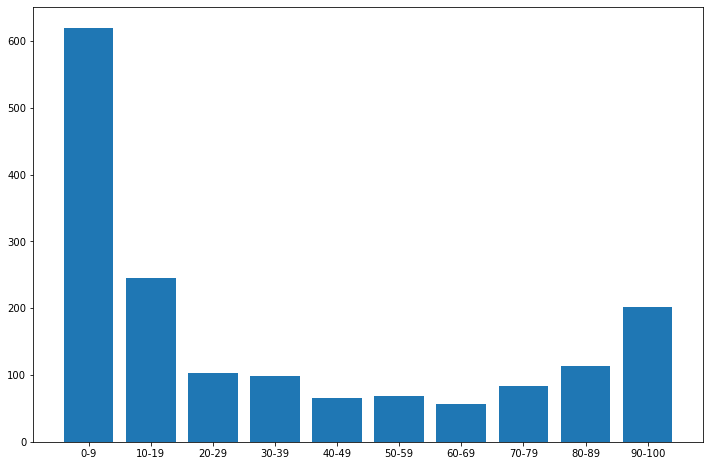

In [152]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12, 8))
plt.bar(keys, values)
plt.show()

In [8]:
### Kui palju kasutajad postitavad? ###
import os
from datetime import datetime
#import datetime

#x=0
fst_lst_tweets = dict()
directory = 'data/EstNLP projektide andmed/2018_est_twitter_plain_texts/div_by_users'
for filename in os.listdir(directory):
    input_file = os.path.join(directory, filename)
    if os.path.isfile(input_file):
        #y=0
        user_tweets = []
        with open(input_file, 'r', encoding='utf-8') as in_file:
            for line in in_file:
                json_line_str = line.strip()
                # Loeme JSON-ist säutsu Text objekti ja meta-andmed
                text_obj, tweet_metadata = json_to_tweet_text( json_text=json_line_str )
                
                date = datetime.strptime(tweet_metadata['created_at'], '%a %b %d %H:%M:%S %z %Y')
                #print(date)

                user_tweets.append(date)
                
                #if y==20:
                #    break
                #y+=1
        
        #print(tweet_metadata['user']['id'], ":\n")
        #print(user_tweets, "\n")
        #print("min:", min(user_tweets), "\n")
        #print("max:", max(user_tweets), "\n")
        fst_lst_tweets[tweet_metadata['user']['id']] = (min(user_tweets), max(user_tweets))
                    
    #if x==25:
    #    break
    #x+=1

In [ ]:
fst_lst_tweets

In [ ]:
%pip install plotly

In [ ]:
%pip install chart-studio

In [ ]:
import pandas as pd
#df = pd.DataFrame.from_dict(fst_lst_tweets, orient='index', columns=['id', 'oldest', 'newest'])
#df = pd.DataFrame(fst_lst_tweets.items(), columns=['id', 'oldest', 'newest'])
#https://stackoverflow.com/questions/46078034/python-dict-with-values-as-tuples-to-pandas-dataframe
df = pd.DataFrame(fst_lst_tweets).T.rename_axis('id').add_prefix('value').reset_index()
#print(df)

#https://stackoverflow.com/questions/53562673/plot-time-periods-in-timeline-from-pandas
df_full = df[['id', 'value0', 'value1']].rename(columns={'id':'Task','value0':'Start','value1':'Finish'}).reset_index()

#import plotly.plotly as py
from chart_studio import plotly as py
import plotly.figure_factory as ff

#fig = ff.create_gantt(df_full)
#py.iplot(fig, filename='gantt-simple-gantt-chart', world_readable=True)
fig = ff.create_gantt(df_full)
fig.show()

In [70]:
### Mis kellaajal kõige rohkem postitatakse? ###
#x=0
tweet_time = dict()
count_days = set()
directory = 'data/EstNLP projektide andmed/2018_est_twitter_plain_texts/div_by_users'
for filename in os.listdir(directory):
    input_file = os.path.join(directory, filename)
    if os.path.isfile(input_file):
        #y=0
        user_tweets = []
        with open(input_file, 'r', encoding='utf-8') as in_file:
            for line in in_file:
                json_line_str = line.strip()
                # Loeme JSON-ist säutsu Text objekti ja meta-andmed
                text_obj, tweet_metadata = json_to_tweet_text( json_text=json_line_str )
                
                date = datetime.strptime(tweet_metadata['created_at'], '%a %b %d %H:%M:%S %z %Y')
                #print(date)
                day = date.strftime("%Y-%m-%d")
                count_days.add(day)
                #print(date_time)
                time = date.strftime('%H:%M')
                if time in tweet_time:
                    tweet_time[time] = tweet_time[time] + 1
                else:
                    tweet_time[time] = 1

                #if y==20:
                #    break
                #y+=1
                    
    #if x==25:
    #    break
    #x+=1

In [71]:
nr_of_days = len(count_days)
avg_tweet_time = dict()
for k, v in tweet_time.items():
    avg_tweet_time[k] = round(v / nr_of_days, 3)

In [75]:
avg_tweet_time_sorted = dict(sorted(avg_tweet_time.items(), key=lambda item: item[1], reverse=True))

In [97]:
print(date)
day = date.strftime("%Y-%m-%d")
print(date_time)
time = day = date.strftime('%H:%M')
print(time)
print(nr_of_days)


2014-07-31 07:23:19+00:00
2018-06-20
07:23
3428


                    time  tweet_count
1117 1900-01-01 00:00:00          327
971  1900-01-01 00:01:00          355
1083 1900-01-01 00:02:00          297
1370 1900-01-01 00:03:00          272
1120 1900-01-01 00:04:00          274
...                  ...          ...
1013 1900-01-01 23:55:00          301
1354 1900-01-01 23:56:00          331
940  1900-01-01 23:57:00          303
1151 1900-01-01 23:58:00          294
898  1900-01-01 23:59:00          344

[1440 rows x 2 columns]


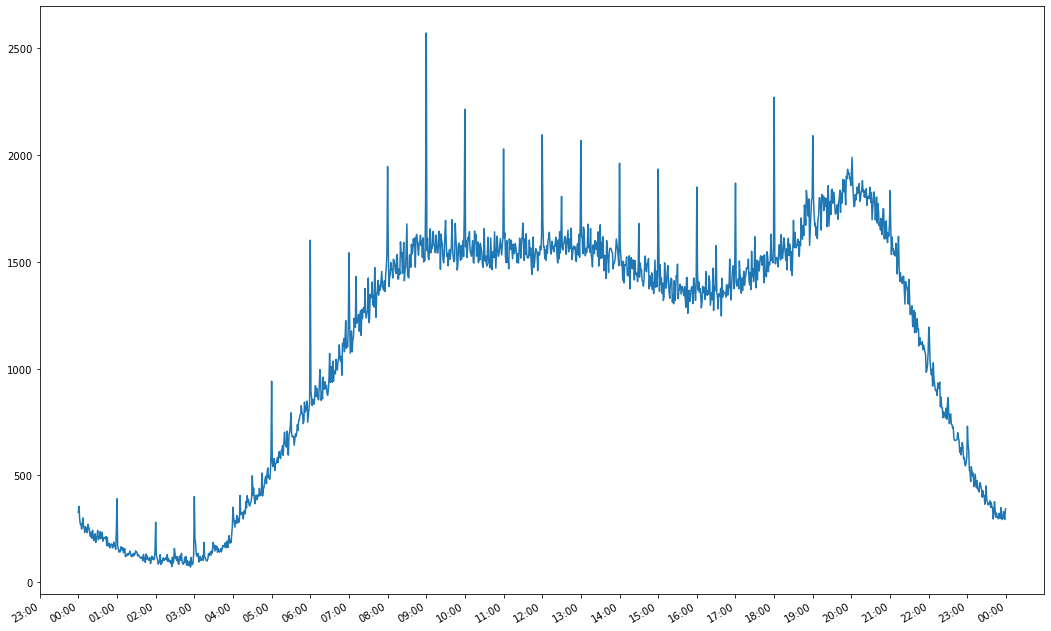

In [101]:
#https://stackoverflow.com/questions/52309415/matplotlib-plot-24-hours-with-1-hour-intervals/52309969
import matplotlib.pyplot as plt
import matplotlib.dates as md
import pandas as pd

df = pd.DataFrame.from_dict(tweet_time, orient='index', columns=['tweet_count']).reset_index()
df = df.rename(columns={'index': 'time'})

df['time'] = pd.to_datetime(df['time'], format='%H:%M')
df = df.sort_values(by=['time'])
print(df)

fig, ax = plt.subplots(figsize=(18,12))

plt.plot('time', 'tweet_count', data=df)
ax.set_xlim(df['time'].min()-pd.Timedelta(1,'h'),
            df['time'].max()+pd.Timedelta(1,'h'))

ax.xaxis.set_major_locator(md.HourLocator(interval = 1))
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))

fig.autofmt_xdate()

plt.show()  

In [ ]:
#Teha csv fail, alustada postitamise tihedusest aastas
#Sama kellaaegadega
#Koondjoonis: postitused aasta(te) lõikes
#Truncated ja RT ajateljele
#Vaadata eraldi created_at

In [20]:
### Kui palju kasutajad postitavad? ###
# Teen sõnastiku, kus on võtmeteks on kuud aastate kaupa ning väärtusteks järjendid
# ennikutest, kus 1. väärtus on kasutaja id ja teiseks postituste arv antud kuul 
# antud aastas
import os
from datetime import datetime
from collections import Counter

#x=0
tweets_by_time = dict()
directory = 'data/EstNLP projektide andmed/2018_est_twitter_plain_texts/div_by_users'
for filename in os.listdir(directory):
    input_file = os.path.join(directory, filename)
    if os.path.isfile(input_file):
        #y=0
        u_tweets = []
        with open(input_file, 'r', encoding='utf-8') as in_file:
            for line in in_file:
                json_line_str = line.strip()
                # Loeme JSON-ist säutsu Text objekti ja meta-andmed
                text_obj, tweet_metadata = json_to_tweet_text( json_text=json_line_str )
                
                date = datetime.strptime(tweet_metadata['created_at'], '%a %b %d %H:%M:%S %z %Y')
                year_month = date.strftime("%Y-%m")
                u_tweets.append(year_month)
                
                #if y==20:
                #    break
                #y+=1
        
        u_tweets_counted = dict(Counter(u_tweets))
        for k, v in u_tweets_counted.items():
            if k in tweets_by_time.keys():
                l = tweets_by_time[k]
                l.append(tuple([tweet_metadata['user']['id'], v]))
            else:
                tweets_by_time[k] = [tuple([tweet_metadata['user']['id'], v])]
                    
    #if x==10:
    #    break
    #x+=1
#print(tweets_by_time)

In [60]:
# Sõnastiku muutmine järjendiks, mis koosneb ennikuteks,
# dataframe-i loomine tehtud järjendist ning selle csv faili kirjutamine
import pandas as pd

#https://stackoverflow.com/questions/45914881/convert-dict-of-lists-of-tuples-to-dataframe
tweets_to_list = [(k, *t) for k, v in tweets_by_time.items() for t in v]
#https://www.geeksforgeeks.org/creating-a-pandas-dataframe-using-list-of-tuples/
df = pd.DataFrame(tweets_to_list, columns=['date','id', 'count'])
df = df.pivot('id', 'date', 'count')
df = df.rename_axis("id").reset_index()
#cols = ['id'] + list(tweets_by_time.keys())
df.to_csv('data/tweeting_activity.csv', encoding='utf-8', index=False)

In [ ]:
# Visualiseerimine
#https://matplotlib.org/stable/gallery/shapes_and_collections/line_collection.html
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import colors as mcolors

import numpy as np

# In order to efficiently plot many lines in a single set of axes,
# Matplotlib has the ability to add the lines all at once. Here is a
# simple example showing how it is done.

segs = [[[100,1000], [100,100]]]

#segs = np.zeros((50, 100, 2))
#segs[:, :, 1] = ys
#segs[:, :, 0] = x
# Mask some values to test masked array support:
#segs = np.ma.masked_where((segs > 50) & (segs < 60), segs)
#print(segs[1])

# We need to set the plot limits.
#plt.figure(figsize=(12, 20))
fig, ax = plt.subplots()
ax.set_xlim(0, 1600)
ax.set_ylim(0, 1200)

labels = [str(x+2008) for x in range(1,12)]
ax.set_yticklabels(labels, fontdict=None)

print(labels)

# *colors* is sequence of rgba tuples.
# *linestyle* is a string or dash tuple. Legal string values are
# solid|dashed|dashdot|dotted.  The dash tuple is (offset, onoffseq) where
# onoffseq is an even length tuple of on and off ink in points.  If linestyle
# is omitted, 'solid' is used.
# See `matplotlib.collections.LineCollection` for more information.
colors = [mcolors.to_rgba(c)
          for c in plt.rcParams['axes.prop_cycle'].by_key()['color']]

line_segments = LineCollection(segs, linewidths=(0.5, 1, 1.5, 2),
                               colors=colors, linestyle='solid')
ax.add_collection(line_segments)
ax.set_title('Line collection with masked arrays')
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(16)
plt.show()

In [ ]:
# Visualiseerimine
#https://matplotlib.org/stable/gallery/shapes_and_collections/line_collection.html
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import colors as mcolors

import numpy as np

# In order to efficiently plot many lines in a single set of axes,
# Matplotlib has the ability to add the lines all at once. Here is a
# simple example showing how it is done.

from datetime import datetime

date_time_str_1 = '09/19'
date_time_obj_1 = datetime.strptime(date_time_str, '%m/%y')

segs = [[[20,0], [20,100]]]

#segs = np.zeros((50, 100, 2))
#segs[:, :, 1] = ys
#segs[:, :, 0] = x
# Mask some values to test masked array support:
#segs = np.ma.masked_where((segs > 50) & (segs < 60), segs)
#print(segs[1])

# We need to set the plot limits.
#plt.figure(figsize=(12, 20))
fig, ax = plt.subplots()
ax.set_xlim(0, 1600)
ax.set_ylim(0, 1200)

labels = [str(x+2008) for x in range(1,12)]
ax.set_yticklabels(labels, fontdict=None)

print(labels)

# *colors* is sequence of rgba tuples.
# *linestyle* is a string or dash tuple. Legal string values are
# solid|dashed|dashdot|dotted.  The dash tuple is (offset, onoffseq) where
# onoffseq is an even length tuple of on and off ink in points.  If linestyle
# is omitted, 'solid' is used.
# See `matplotlib.collections.LineCollection` for more information.
colors = [mcolors.to_rgba(c)
          for c in plt.rcParams['axes.prop_cycle'].by_key()['color']]

line_segments = LineCollection(segs, linewidths=(0.5, 1, 1.5, 2),
                               colors=colors, linestyle='solid')
ax.add_collection(line_segments)
ax.set_title('Line collection with masked arrays')
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(16)
plt.show()

In [78]:
# Sorteerin fst_lst_tweets sõnastiku esimese ja viimase postituse vahel oleva aja järgi - pikem vahe eespool
sorted_fst_last = {k: v for k, v in sorted(fst_lst_tweets.items(), key=lambda item: item[1][1]-item[1][0], reverse=True)}

# Korjan joonise jaoks ymin ja ymax koordinaadid fst_lst_tweets sõnastikust
# x-koordinaat on kasutaja positsioon sõnastikus
x = []
ymin = []
ymax = []
x_count = 1
for u in sorted_fst_last.items():
    #print(u)
    # datetime kujule kuu-aasta
    #first = datetime.strptime(u[1][0].strftime("%m-%Y"), "%m-%Y")
    ymin.append(u[1][0])
    ymax.append(u[1][1])
    x.append(x_count)
    x_count += 1

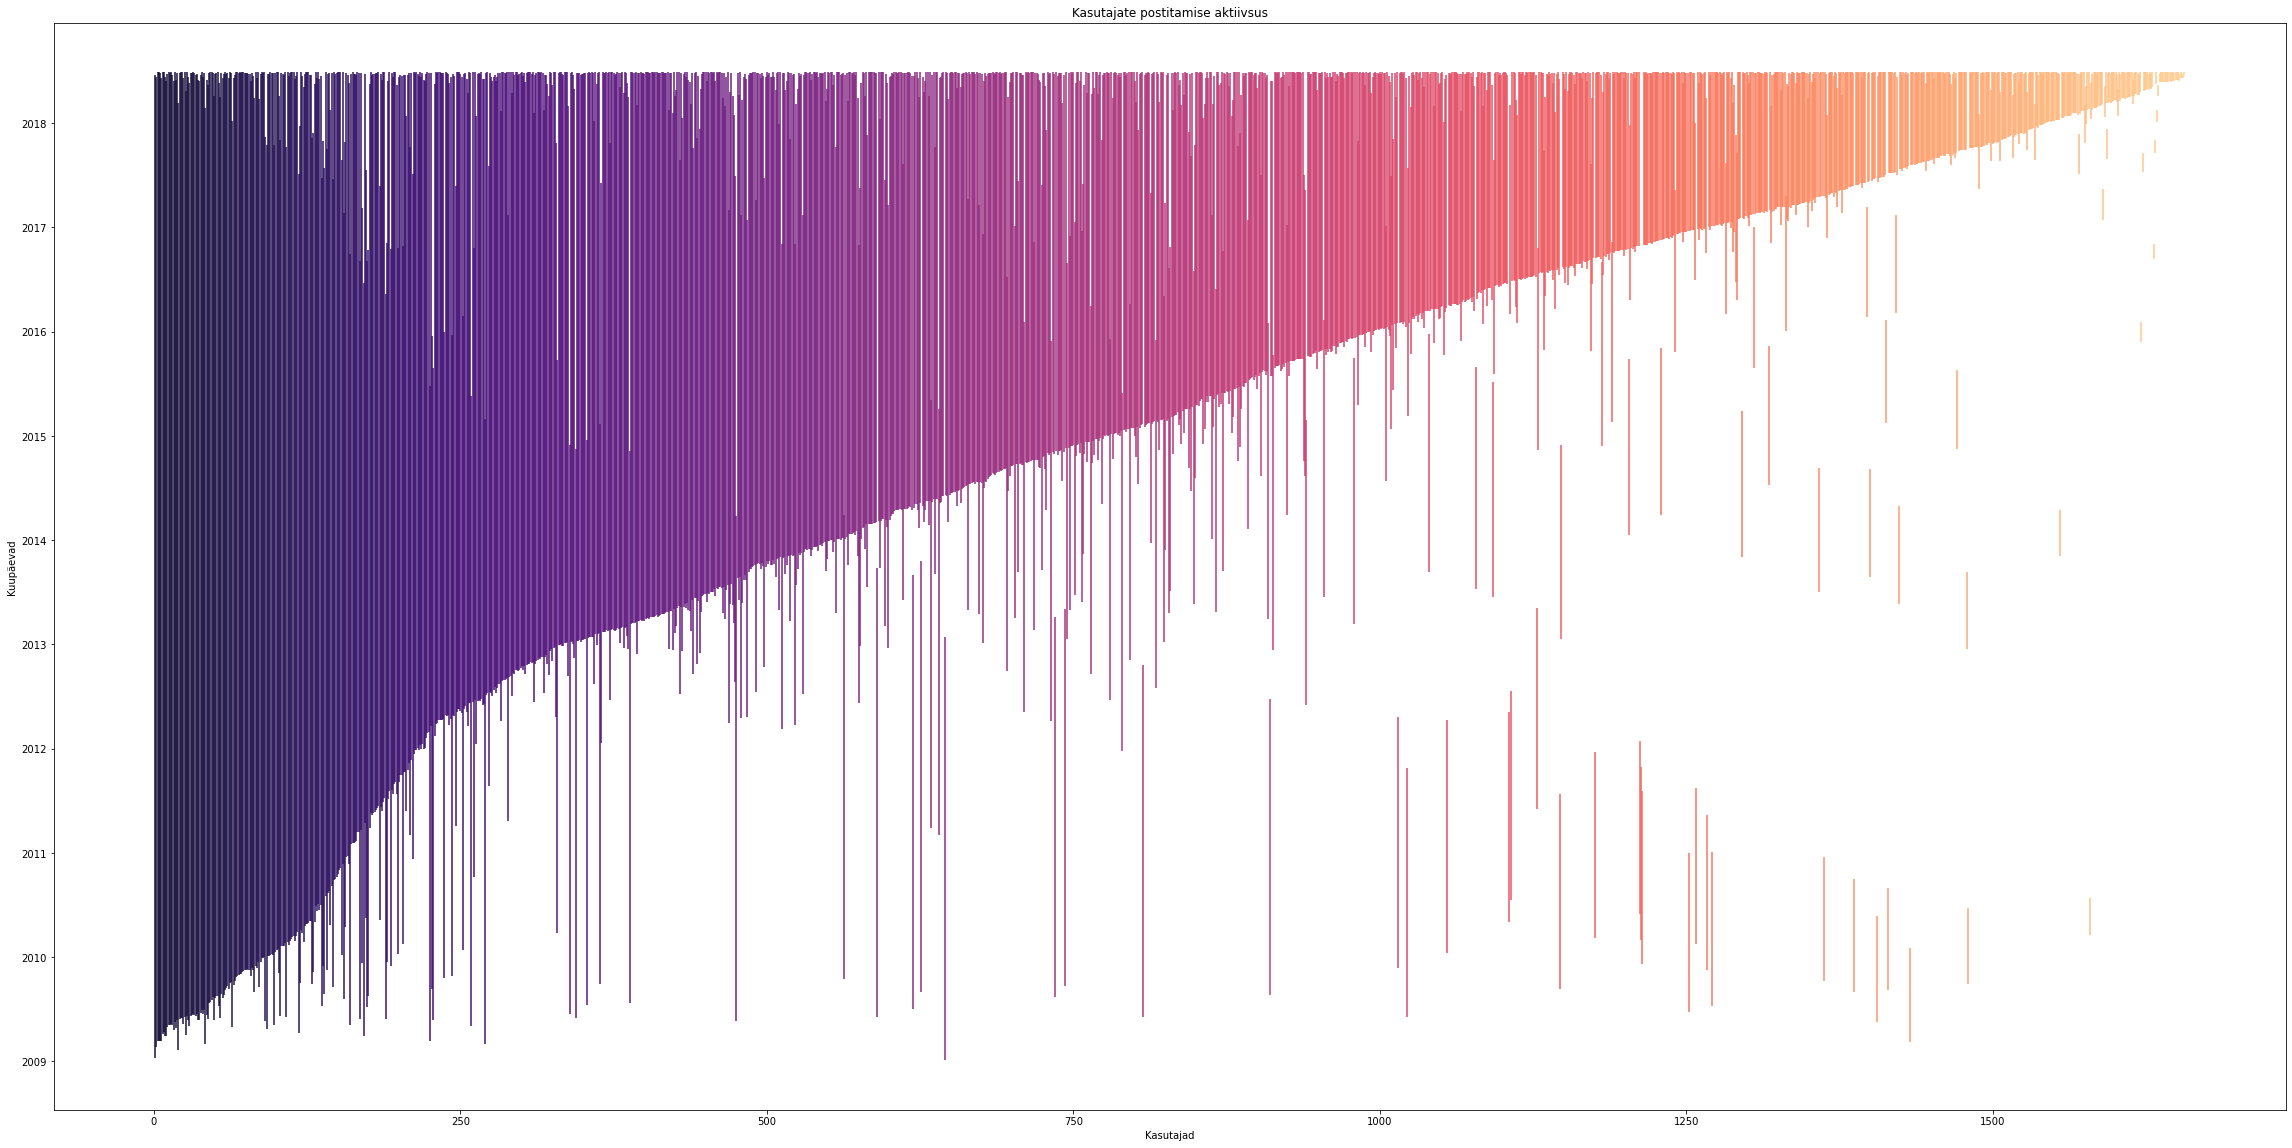

In [79]:
import matplotlib.pyplot as plt
import matplotlib as mpl

#https://stackoverflow.com/questions/30079590/use-matplotlib-color-map-for-color-cycle
n = len(fst_lst_tweets)
color = plt.cm.magma(np.linspace(0.1,0.9,n)) # This returns RGBA; convert:
#hexcolor = map(lambda rgb:'#%02x%02x%02x' % (rgb[0]*255,rgb[1]*255,rgb[2]*255),
#               tuple(color[:,0:-1]))

plt.figure(figsize=(40, 20))
plt.vlines(x, ymin, ymax, color=color)
plt.xlabel("Kasutajad")
plt.ylabel("Kuupäevad")
plt.title("Kasutajate postitamise aktiivsus")
plt.show()


In [67]:
# Sorteerin fst_lst_tweets sõnastiku esimese ja viimase postituse vahel oleva aja järgi - pikem vahe eespool
sorted_fst_last = {k: v for k, v in sorted(fst_lst_tweets.items(), key=lambda item: item[1][1], reverse=False)}

# Korjan joonise jaoks ymin ja ymax koordinaadid fst_lst_tweets sõnastikust
# x-koordinaat on kasutaja positsioon sõnastikus
x = []
ymin = []
ymax = []
x_count = 1
for u in sorted_fst_last.items():
    #print(u)
    # datetime kujule kuu-aasta
    #first = datetime.strptime(u[1][0].strftime("%m-%Y"), "%m-%Y")
    ymin.append(u[1][0])
    ymax.append(u[1][1])
    x.append(x_count)
    x_count += 1

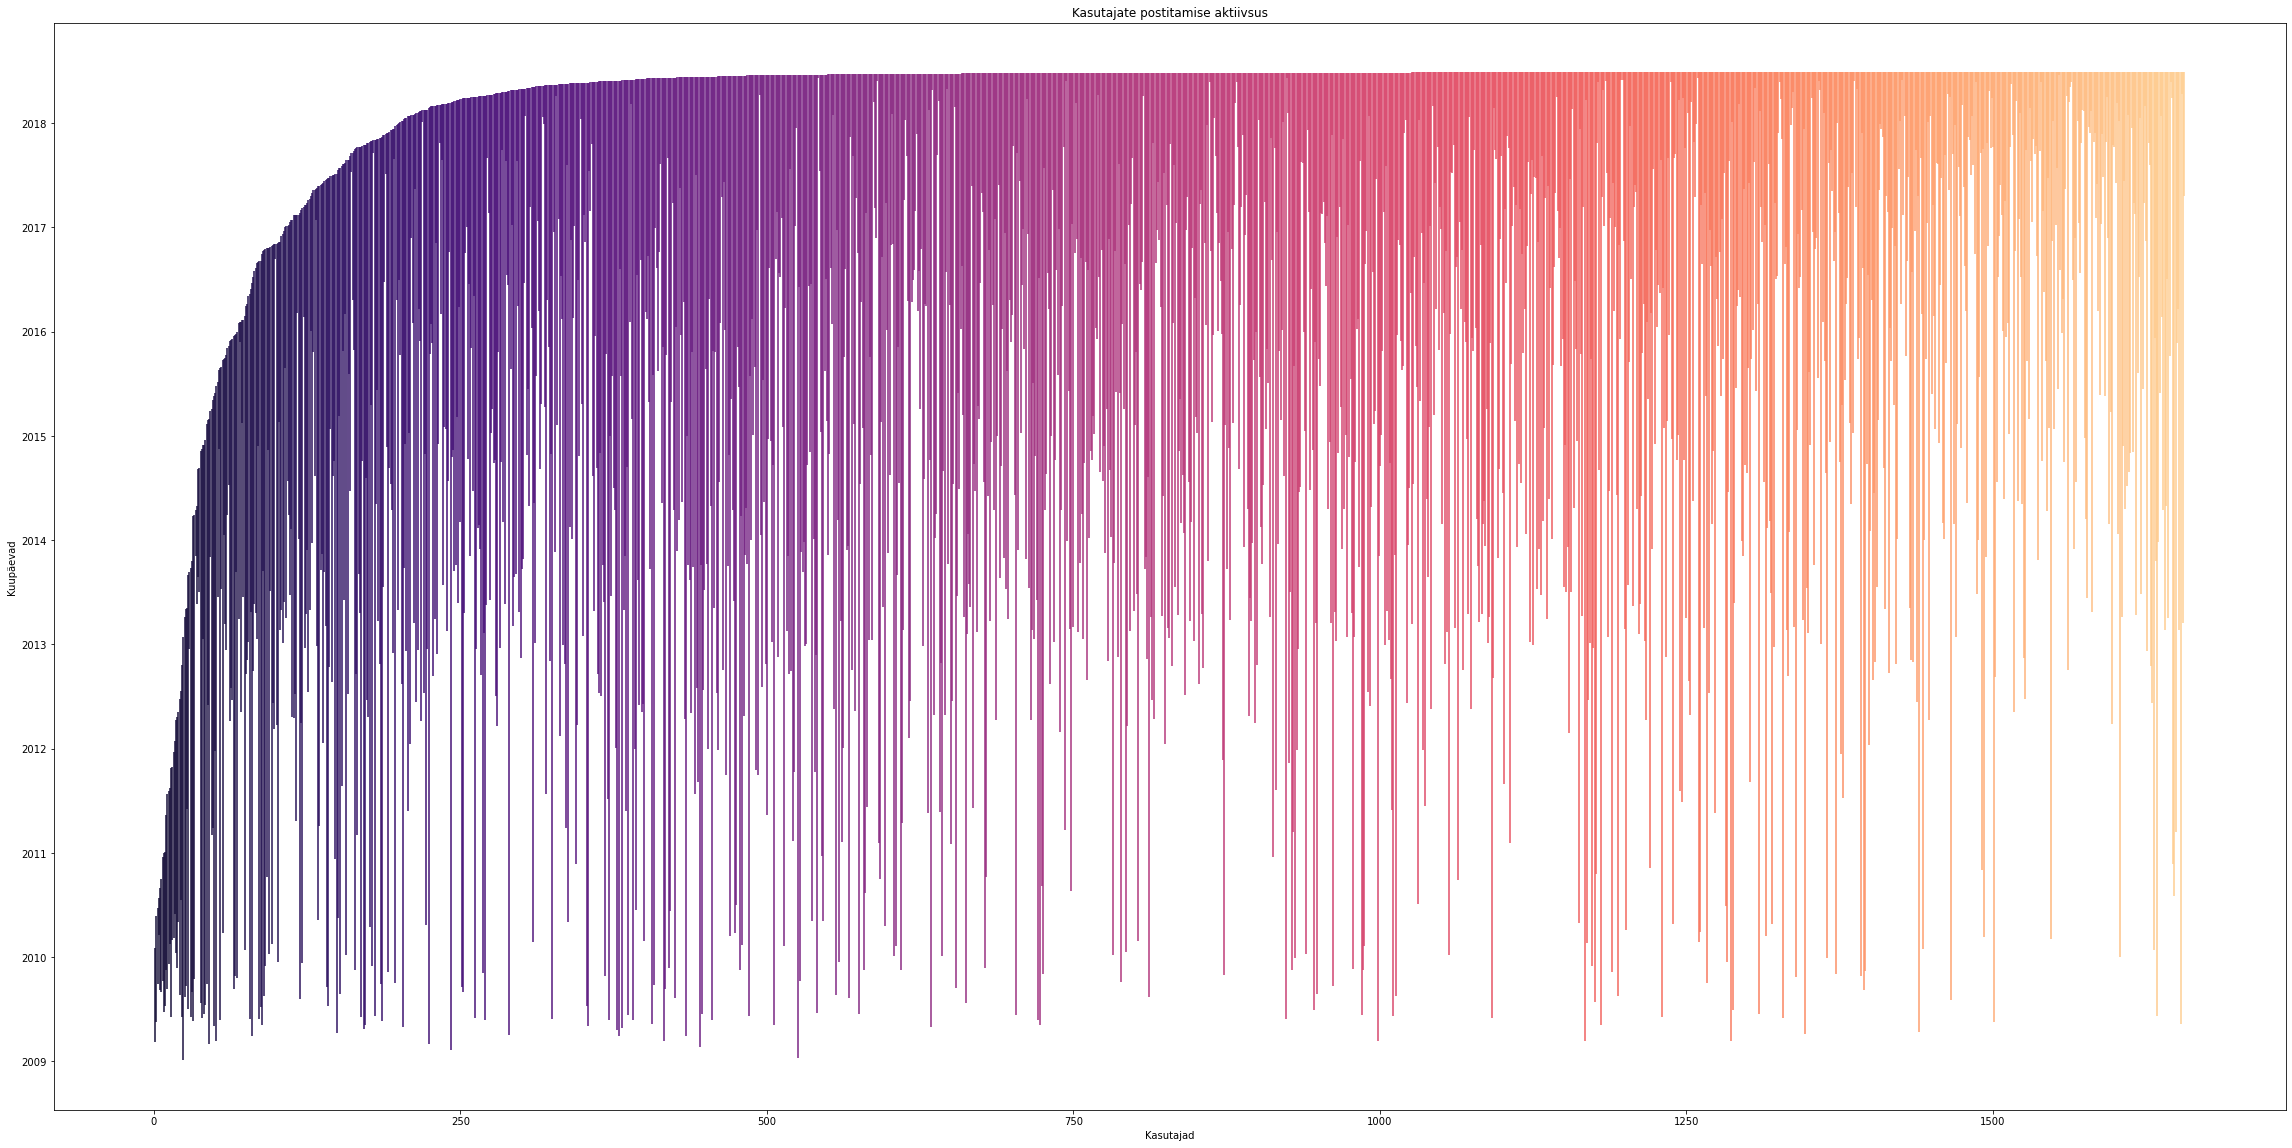

In [68]:
import matplotlib.pyplot as plt
import matplotlib as mpl

#https://stackoverflow.com/questions/30079590/use-matplotlib-color-map-for-color-cycle
n = len(fst_lst_tweets)
color = plt.cm.magma(np.linspace(0.1,0.9,n)) # This returns RGBA; convert:
hexcolor = map(lambda rgb:'#%02x%02x%02x' % (rgb[0]*255,rgb[1]*255,rgb[2]*255),
               tuple(color[:,0:-1]))

plt.figure(figsize=(40, 20))
plt.vlines(x, ymin, ymax, color=color)
plt.xlabel("Kasutajad")
plt.ylabel("Kuupäevad")
plt.title("Kasutajate postitamise aktiivsus")
plt.show()

In [69]:
# Sorteerin fst_lst_tweets sõnastiku esimese ja viimase postituse vahel oleva aja järgi - pikem vahe eespool
sorted_fst_last = {k: v for k, v in sorted(fst_lst_tweets.items(), key=lambda item: item[1][0], reverse=False)}

# Korjan joonise jaoks ymin ja ymax koordinaadid fst_lst_tweets sõnastikust
# x-koordinaat on kasutaja positsioon sõnastikus
x = []
ymin = []
ymax = []
x_count = 1
for u in sorted_fst_last.items():
    #print(u)
    # datetime kujule kuu-aasta
    #first = datetime.strptime(u[1][0].strftime("%m-%Y"), "%m-%Y")
    ymin.append(u[1][0])
    ymax.append(u[1][1])
    x.append(x_count)
    x_count += 1

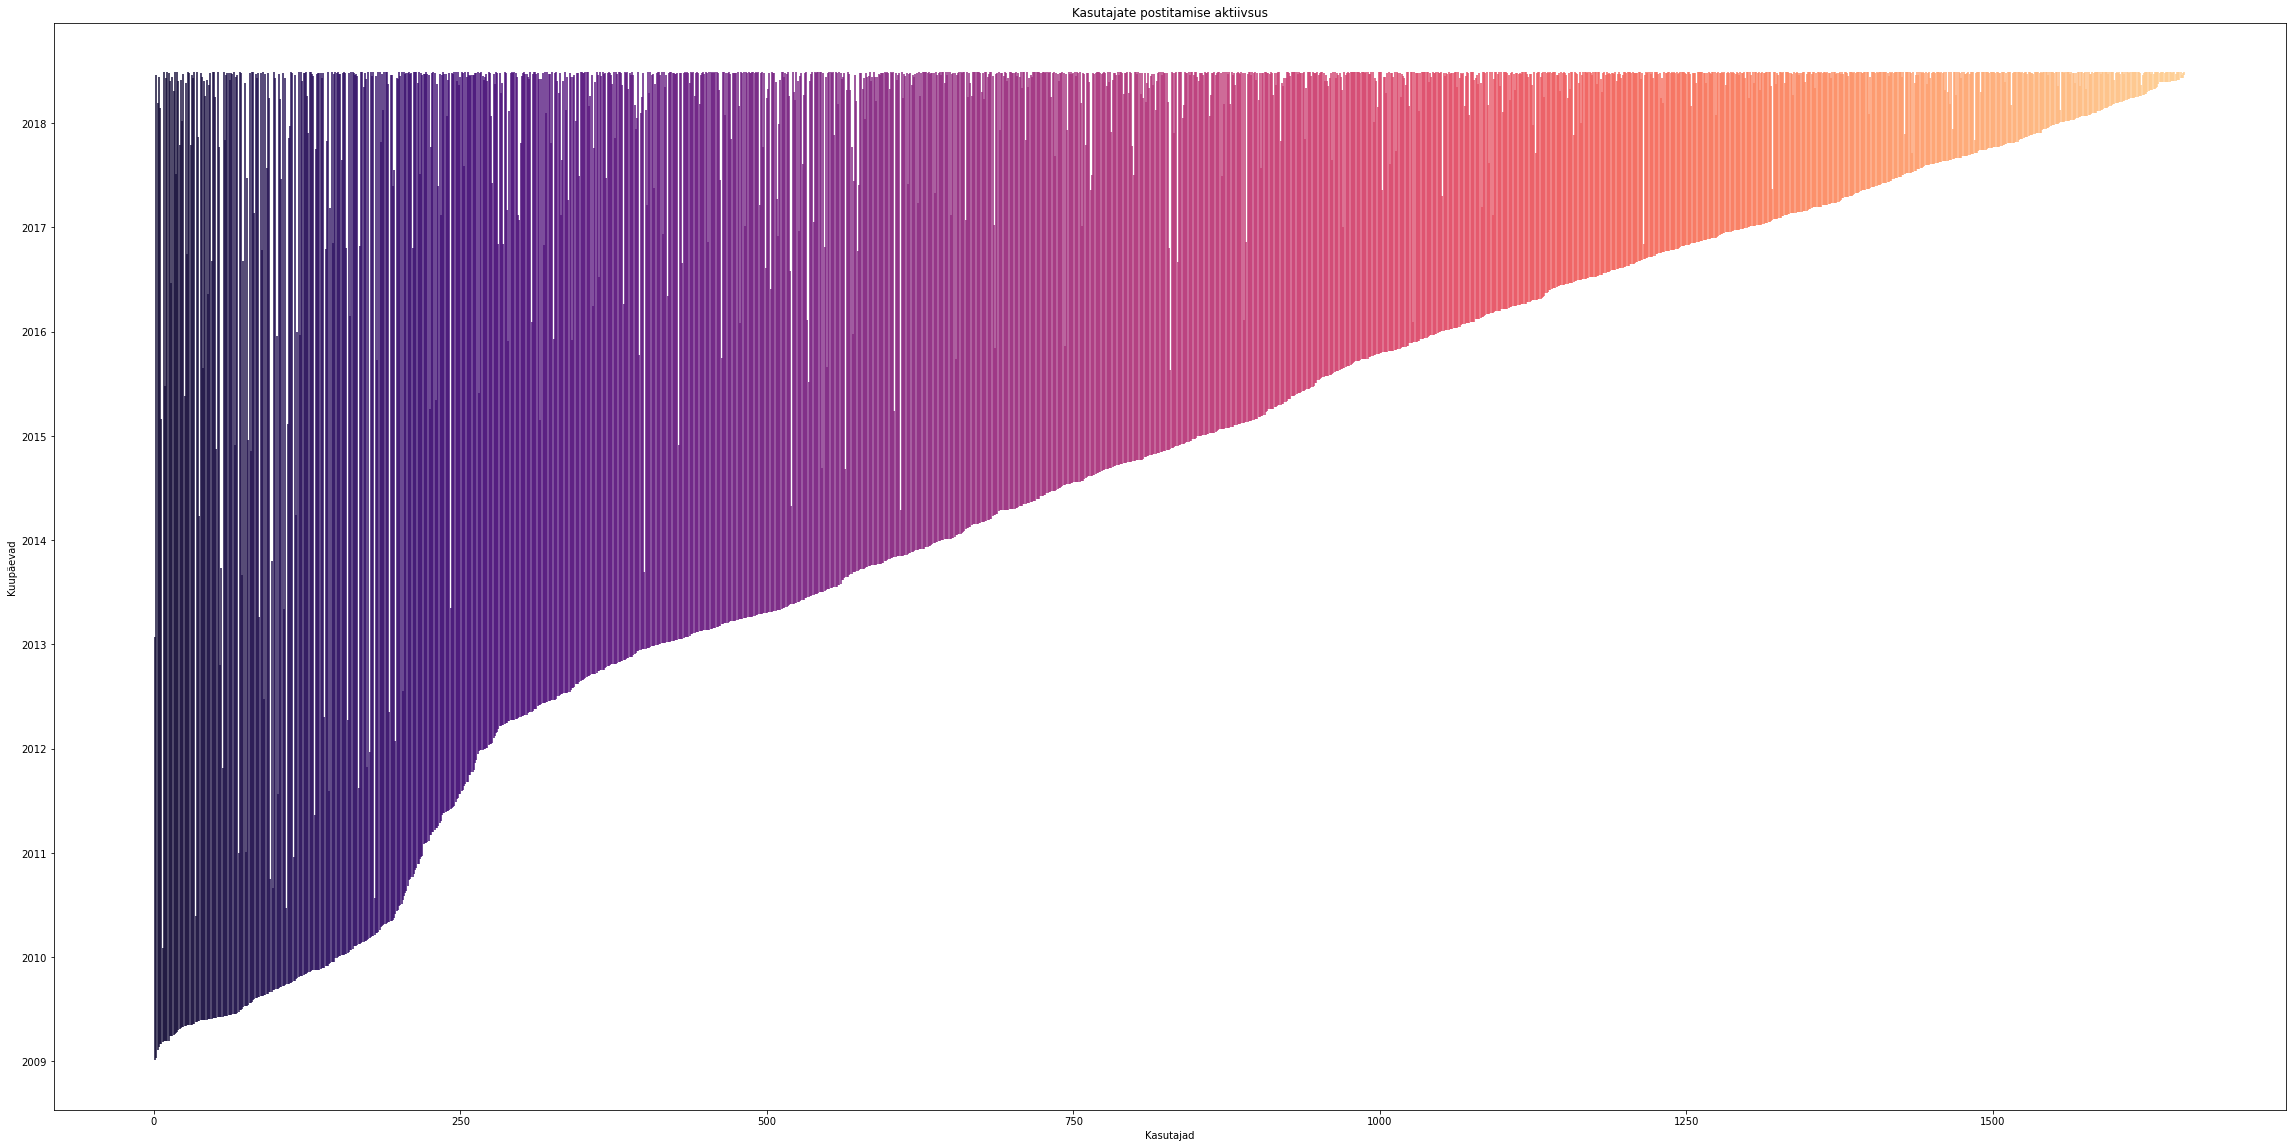

In [70]:
import matplotlib.pyplot as plt
import matplotlib as mpl

#https://stackoverflow.com/questions/30079590/use-matplotlib-color-map-for-color-cycle
n = len(fst_lst_tweets)
color = plt.cm.magma(np.linspace(0.1,0.9,n)) # This returns RGBA; convert:
hexcolor = map(lambda rgb:'#%02x%02x%02x' % (rgb[0]*255,rgb[1]*255,rgb[2]*255),
               tuple(color[:,0:-1]))

plt.figure(figsize=(40, 20))
plt.vlines(x, ymin, ymax, color=color)
plt.xlabel("Kasutajad")
plt.ylabel("Kuupäevad")
plt.title("Kasutajate postitamise aktiivsus")
plt.show()

In [ ]:
#grupeerida pidevuse järgi
# a) postitused aasta kaupa
# b) kuude kaupa
#arvutada protsendid, teha tabel
#kategooriad (org, per)
#lisada üldiseid jooniseid, lisada rt, trunc joon
#mõelda kirjaliku osa peale

In [26]:
tweet_count = dict()
labels = [str(x+2008) for x in range(1,12)]
del labels[-1]
for x in labels:
    tweet_count[x] = [0, 0, 0]
print(tweet_count)

{'2009': [0, 0, 0], '2010': [0, 0, 0], '2011': [0, 0, 0], '2012': [0, 0, 0], '2013': [0, 0, 0], '2014': [0, 0, 0], '2015': [0, 0, 0], '2016': [0, 0, 0], '2017': [0, 0, 0], '2018': [0, 0, 0]}


In [29]:
from datetime import datetime

tweet_count = dict()
labels = [str(x+2008) for x in range(1,12)]
del labels[-1]
for x in labels:
    tweet_count[x] = [0, 0, 0]

input_file = 'data/EstNLP projektide andmed/2018_est_twitter_plain_texts/est_twitter_2018_june_plain_texts_edited.jsonl'

x=0
with open(input_file, 'r', encoding='utf-8') as in_file:
    for line in in_file:
        json_line_str = line.strip()
        # Loeme JSON-ist säutsu Text objekti ja meta-andmed
        text_obj, tweet_metadata = json_to_tweet_text( json_text=json_line_str )

        date = datetime.strptime(tweet_metadata['created_at'], '%a %b %d %H:%M:%S %z %Y')
        year = date.strftime("%Y")
        #trunc, rt, count
        #[0, 0, 0]
        if tweet_metadata['is_retweeted'] is True:
            tweet_count[year][1]+=1
            
        if tweet_metadata['is_truncated'] is True:
            tweet_count[year][0]+=1
            
        tweet_count[year][2]+=1

        #if x==2:
        #    break
        #x+=1

In [30]:
tweet_count

{'2009': [0, 538, 15746],
 '2010': [0, 1192, 25042],
 '2011': [3, 908, 28412],
 '2012': [8, 1279, 57771],
 '2013': [1011, 5498, 134299],
 '2014': [3326, 17490, 170499],
 '2015': [8648, 46830, 193169],
 '2016': [16627, 83614, 242069],
 '2017': [34802, 192831, 389727],
 '2018': [38761, 183072, 348068]}

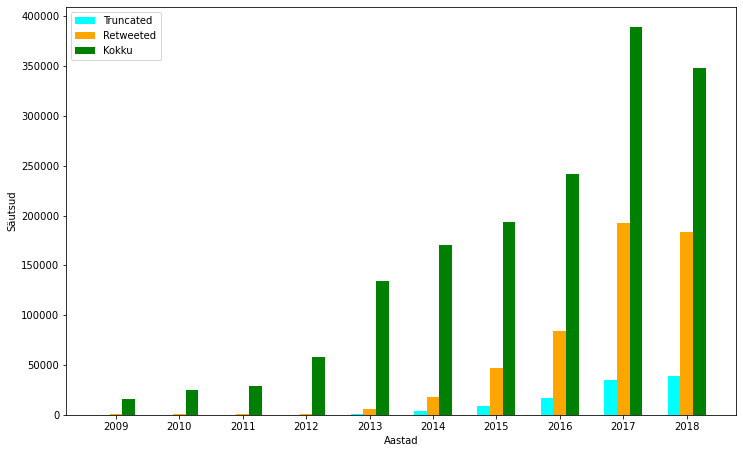

In [36]:
# 1) säutsud perioodil 2009-2018: kolm joont: säutsude arv, taaspostituste ehk retweet-ide arv, 
# lühendatud ehk truncated säutsude arv
# https://www.geeksforgeeks.org/create-a-grouped-bar-plot-in-matplotlib/
# Miks RT tõuseb hilisematel aastatel?
import matplotlib.pyplot as plt
import numpy as np

# create data
x = np.arange(10)
y1=[]
y2=[]
y3=[]
for v in tweet_count.values():
    y1.append(v[0])
    y2.append(v[1])
    y3.append(v[2])
width = 0.2
  
# plot data in grouped manner of bar type
plt.figure(figsize=(12, 7.5))
plt.bar(x-0.2, y1, width, color='cyan')
plt.bar(x, y2, width, color='orange')
plt.bar(x+0.2, y3, width, color='green')
plt.xticks(x, labels)
plt.xlabel("Aastad")
plt.ylabel("Säutsud")
plt.legend(["Truncated", "Retweeted", "Kokku"])
plt.show()

In [15]:
# Laeme sisse kasutajanimede klassifitseeringud (PER vs ORG)
usernames_classification_file = 'data/EstNLP projektide andmed/2018_est_twitter_plain_texts/twitter_usernames_persons_vs_orgs.txt'

user_classes = dict()
with open(usernames_classification_file, 'r', encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        if line.startswith('#'): # jätame kommentaarirea vahele
            continue
        if line.count('|') > 1:
            parts_of_line = line.split('|')
            usr_class      = parts_of_line[0].strip()
            usr_screenname = parts_of_line[1].strip()
            user_classes[usr_screenname] = usr_class

In [11]:
# Laeme sisse PER kasutajanimede soo klassifitseeringud (M, F, UNK)
usernames_gender_file = 'data/EstNLP projektide andmed/2018_est_twitter_plain_texts/twitter_username_genders.txt'

user_genders = dict()
with open(usernames_gender_file, 'r', encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        if line.startswith('#'): # jätame kommentaarirea vahele
            continue
        if line.count('|') > 1:
            parts_of_line = line.split('|')
            usr_gender     = parts_of_line[0].strip()
            usr_screenname = parts_of_line[1].strip()
            user_genders[usr_screenname] = usr_gender

In [41]:
# 2) "aktiivsed kasutajad" perioodil 2009-2018: kuipalju oli neid, kes tegid vaadeldaval 
# aastal vähemalt ühe säutsu?
import os
from datetime import datetime

tweet_count = dict()
labels = [str(x+2008) for x in range(1,12)]
del labels[-1]
for x in labels:
    tweet_count[x] = [0, 0, 0, 0, 0]

x=0
active_yrs_all = []
directory = 'data/EstNLP projektide andmed/2018_est_twitter_plain_texts/div_by_users'
for filename in os.listdir(directory):
    input_file = os.path.join(directory, filename)
    if os.path.isfile(input_file):
        #y=0
        rt=0
        count=0
        active_yrs = set()
        with open(input_file, 'r', encoding='utf-8') as in_file:
            for line in in_file:
                json_line_str = line.strip()
                # Loeme JSON-ist säutsu Text objekti ja meta-andmed
                text_obj, tweet_metadata = json_to_tweet_text( json_text=json_line_str )
                #display(text_obj)
                #pprint(tweet_metadata)
                date = datetime.strptime(tweet_metadata['created_at'], '%a %b %d %H:%M:%S %z %Y')
                active_yrs.add(date.strftime("%Y")) 

                #if y==2:
                #    break
                #y+=1
        
        #tweet_count[tweet_metadata['user']['id']] = {'total_tweets': count, 'retweets': rt, 'proportion': round(rt / count * 100, 2)}
        current_user = text_obj.meta['screen_name']
        if current_user in user_classes.keys():
            current_user_class  = user_classes[current_user]
            # NB: sugu on määratud ainult PER tüüpi kasutajatele
            #
            current_user_gender = user_genders.get(current_user, None)
        else:
            current_user_class = 'unk'
            current_user_gender = 'unk'
        
        #print(current_user_class, current_user_gender)
        #gender =
        
        active_yrs_all.append(active_yrs)
        
        for y in active_yrs:
            # kõik kasutajad
            tweet_count[y][2]+=1
            # PER
            if current_user_class == 'PER':
                tweet_count[y][1]+=1
                # F
                if current_user_gender == 'F':
                    tweet_count[y][3]+=1
                # M
                elif current_user_gender == 'M':
                    tweet_count[y][4]+=1
            # ORG
            elif current_user_class == 'ORG':
                tweet_count[y][0]+=1
                
    #if x==2:
    #    break
    #x+=1

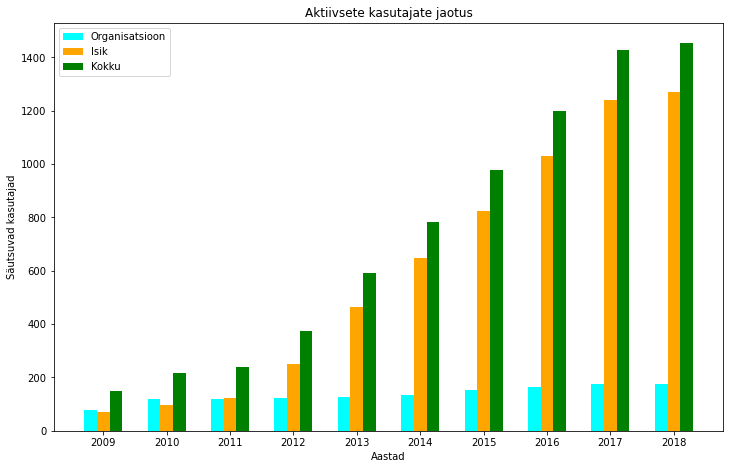

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# create data
x = np.arange(10)
y1=[]
y2=[]
y3=[]
for v in tweet_count.values():
    y1.append(v[0])
    y2.append(v[1])
    y3.append(v[2])
width = 0.2
  
# plot data in grouped manner of bar type
plt.figure(figsize=(12, 7.5))
plt.bar(x-0.2, y1, width, color='cyan')
plt.bar(x, y2, width, color='orange')
plt.bar(x+0.2, y3, width, color='green')
plt.xticks(x, labels)
plt.xlabel("Aastad")
plt.ylabel("Säutsuvad kasutajad")
plt.legend(["Organisatsioon", "Isik", "Kokku"])
plt.title("Aktiivsete kasutajate jaotus")
plt.show()

INFO:category.py:227: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:category.py:227: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:category.py:227: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:category.py:227: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:category.py:227: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as 

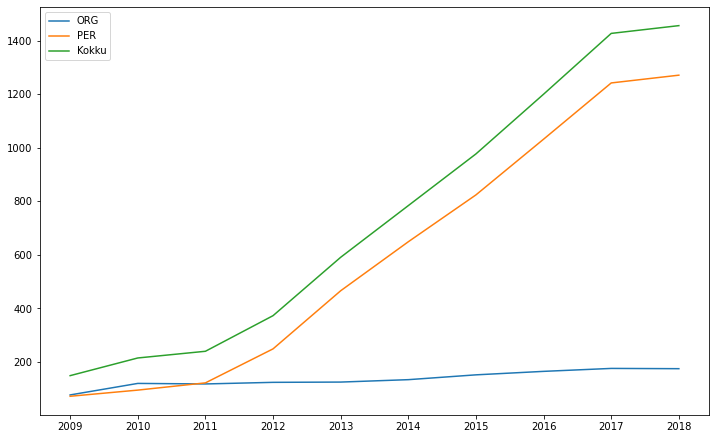

In [40]:
plt.figure(figsize=(12, 7.5))
plt.plot(labels, y1, label = "ORG")
plt.plot(labels, y2, label = "PER")
plt.plot(labels, y3, label = "Kokku")

plt.legend()
plt.show()

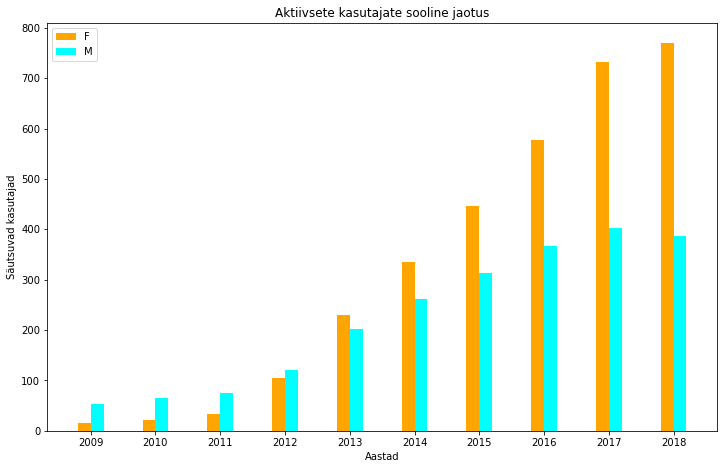

In [47]:
# create data
x = np.arange(10)
y1=[]
y2=[]
for v in tweet_count.values():
    y1.append(v[3])
    y2.append(v[4])
width = 0.2
  
# plot data in grouped manner of bar type
plt.figure(figsize=(12, 7.5))
plt.bar(x-0.1, y1, width, color='orange')
plt.bar(x+0.1, y2, width, color='cyan')
plt.xticks(x, labels)
plt.xlabel("Aastad")
plt.ylabel("Säutsuvad kasutajad")
plt.legend(["F", "M"])
plt.title("Aktiivsete kasutajate sooline jaotus")
plt.show()

In [66]:
# sagedus + pidevus
tweet_count = dict()
labels = [str(x+2008) for x in range(1,12)]
del labels[-1]
for x in labels:
    tweet_count[x] = [0, 0, 0]

for u in active_yrs_all:
    yrs_int = [int(x) for x in u]
    yrs_int.sort()
    last = 0
    before_last = 0
    b_before_last = 0
    for y in yrs_int:
        # Postitab vaadeldaval aastal, kuid mitte kahel eelneval
        if y - last > 1:
            tweet_count[str(y)][0]+=1
        # Postitab vaadeldaval ja eelmisel aastal, kuid mitte üle-eelmisel
        elif y - last == 1 and y - before_last > 2:
            tweet_count[str(y)][1]+=1
        # Postitab vaadeldaval, eelmisel ja üleeelmisel aastal
        elif y - last == 1 and y - before_last == 2 and b_before_last > 3:
            tweet_count[str(y)][2]+=1
        
        b_before_last = before_last
        before_last = last
        last = y
        


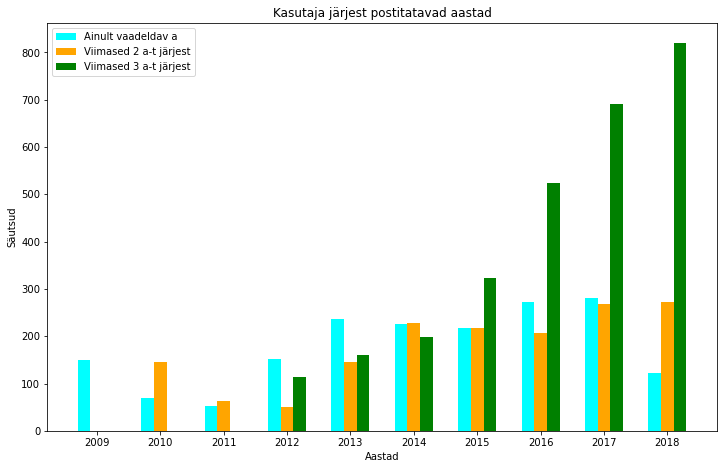

In [69]:
import matplotlib.pyplot as plt
import numpy as np

# create data
x = np.arange(10)
y1=[]
y2=[]
y3=[]
for v in tweet_count.values():
    y1.append(v[0])
    y2.append(v[1])
    y3.append(v[2])
width = 0.2
  
# plot data in grouped manner of bar type
plt.figure(figsize=(12, 7.5))
plt.bar(x-0.2, y1, width, color='cyan')
plt.bar(x, y2, width, color='orange')
plt.bar(x+0.2, y3, width, color='green')
plt.xticks(x, labels)
plt.xlabel("Aastad")
plt.ylabel("Säutsud")
plt.legend(["Ainult vaadeldav a", "Viimased 2 a-t järjest", "Viimased 3 a-t järjest"])
plt.title("Kasutaja järjest postitatavad aastad")
plt.show()

In [ ]:
# Tabel: mitu a järjest kasutaja postitanud on
# Uurida kellaaegade joonise teravikke